In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import cupy as cp
from collections import defaultdict
# TODO: Fix cp_smallest_sample_size() so that you can run it many times and get the same result.

C:\ProgramData\Anaconda3\lib\site-packages\cupy\_environment.py:435: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda115

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
def load_data(filepath):
    df = pd.read_pickle(filepath)
    return df

In [28]:
def split_by_event(df, columns=None):
    ''' Groups data into separate dataframes by data collection event.
    INPUTS: df: pandas DataFrame
            columns (optional): Array-like referring to the desired column names.
                                Defaults to all columns, but specifying can save memory and computation time.
    OUTPUT: df_dict: a dictionary of DataFrames or arrays where each key refers to a single data gathering event.
    '''
    if columns is None:
        col = df.columns
    else:
        col = columns
        
    df_dict = {}
    for time_period in df['Even_mon'].unique():
        df_dict[time_period] = df[df['Even_mon'] == time_period][col]
    return df_dict


In [29]:
def split_by_factor(df, factor, columns=None):
    ''' Groups data into separate dataframes by a column. Best used after split_by_event()
    INPUTS: 
    df: (pandas DataFrame) the data to be split
    factor: (str) refers to the column by which the data will be divided
    columns (optional): (array-like) refers to the desired column names.
                        Defaults to all columns, but specifying can save memory and computation time.
    OUTPUT: 
    df_dict: (dict) stores DataFrames or arrays where each key refers to a unique factor value.
    '''
    if columns is None:
        col = df.columns
    else:
        col = columns
        
    df_dict = {}
    for factor_value in df[factor].unique():
        df_dict[factor_value] = df[df[factor] == factor_value][col]
    return df_dict

In [7]:
def cp_smallest_sample_size(data, n_sims=10_000, starting_sample_size=100, learning_rate=10, z_max=0.1, conf=0.99):
    ''' Simulates randomly selected points from an array to get the smallest sample size that fits 
        the parameters of the data, to a 95% confidence interval.
        Works best when run multiple times to get a distribution of sample sizes. uses CuPy instead of NumPy.
    INPUTS:
    data: (array-like) data to be selected from
    stat: (str) 'mean' or 'std', will perform the necessary calculation based on mean or standard deviation.
    n-sims: (int) the number of times data will be randomly selected from the original
    starting_sample-size: (int) default 100, the number of data points randomly selected
    learning_rate: (int) the value by which the sample size will be incremented to increase precision
    z-max: (float) indicates the desired closeness to the mean of the original data. a z-value of ~0.1
            implies the simulated mean falls within about a 8% confidence interval of the parameter.
    conf: (float) 0-1. the degree of confidence that a sample mean will fall within z_max of the population mean.
    OUTPUT:
    smallest_stable_sample: (int) represents a population size for accurate sampling given the parameters.
    '''
    n_obs = data.shape[0]

    confidence = conf
    sim_stat = 0
    unstable = True
    
    #Find the mean and standard deviation of the population
    pop_mean = data.mean()
    pop_std = data.std()
    
    # if standard deviation is 0 it usually means size is 1
    if (pop_std == 0) or pd.isna(pop_std):
        return n_obs
    
    size_list = []
    sample_size = starting_sample_size
    # Rapidly approach a minimum viable sample size
    while np.abs((sim_stat - pop_mean)/pop_std) > z_max:
        sample_props = cp.random.choice(data, size=(1, sample_size))
        sim_stat = sample_props.mean()

        del sample_props
        sample_size += learning_rate
        if sample_size >= n_obs:
            return n_obs
            # skip the next step if sample size increases to max


    # Increment sample size more slowly until it satisfies confidence criteria
    while unstable:
        sim_stat_list = []


        sample_props = cp.random.choice(data, size=(n_sims, sample_size))
        np_props = cp.asnumpy(sample_props)
        del sample_props
        for arr in np_props:
            sim_stat_list.append(arr.mean())

        accept = 0
        reject = 0
        for sim_stat in sim_stat_list:
            if np.abs((sim_stat - pop_mean)/pop_std) > z_max:
                reject += 1
            else:
                accept += 1
        if (1-reject/accept) <= confidence:
            sample_size += learning_rate
        else:
            unstable = False
 
        if sample_size >= n_obs:
            return n_obs

   
    return sample_size

In [8]:
def get_smallest_sample_size(data, n_sims=10_000, starting_sample_size=100, learning_rate=10, z_max=0.065):
    ''' Simulates randomly selected points from an array to get the smallest sample size that fits 
        the parameters of the data, to a 95% confidence interval.
        Works best when run multiple times to get a distribution of sample sizes. uses CuPy instead of NumPy.
    INPUTS:
    data: (array-like) data to be selected from
    stat: (str) 'mean' or 'std', will perform the necessary calculation based on mean or standard deviation.
    n-sims: (int) the number of times data will be randomly selected from the original
    starting_sample-size: (int) default 100, the number of data points randomly selected
    learning_rate: (int) the value by which the sample size will be incremented to increase precision
    z-max: (float) indicates the desired closeness to the mean of the original data. a z-value of ~0.065
            implies the simulated mean falls within about a 5% confidence interval of the parameter.
    OUTPUT:
    smallest_stable_sample: (int) represents a population size for accurate sampling given the parameters.
    '''
    n_obs = data.shape[0]

    confidence = .95
    sim_stat = 0
    unstable = True
    
    #Find the mean and standard deviation of the population
    pop_mean = data.mean()
    pop_std = data.std()
    
    # if standard deviation is 0 it usually means size is 1
    if (pop_std == 0) or pd.isna(pop_std):
        return n_obs
    
    size_list = []
    sample_size = starting_sample_size
    # Rapidly approach a minimum viable sample size
    while np.abs((sim_stat - pop_mean)/pop_std) > z_max:
        sample_props = np.random.choice(data, size=(1, sample_size))
        sim_stat = sample_props.mean()

        sample_size += learning_rate
        if sample_size >= n_obs:
            return n_obs
            # skip the next step if sample size increases to max


    # Increment sample size more slowly until it satisfies confidence criteria
    while unstable:
        sim_stat_list = []

        for n in range(n_sims):
            sample_props = np.random.choice(data, size=(1, sample_size))
            sim_stat_list.append(sample_props.mean())

        accept = 0
        reject = 0
        for sim_stat in sim_stat_list:
            if np.abs((sim_stat - pop_mean)/pop_std) > z_max:
                reject += 1
            else:
                accept += 1
        if (1-reject/accept) <= confidence:
            sample_size += learning_rate
        else:
            unstable = False
 
        if sample_size >= n_obs:
            return n_obs

   
    return sample_size

In [9]:
def split_data(df, sim_cols, group_cols):
    '''Takes the dataframe, splits it into arrays for every permutation of sim_cols by group_cols.
    INPUTS:
    df: (DataFrame) the full dataset to be split.
    sim_cols: (list) the columns containing the data to be simulated.
    group_cols: (list) the columns by which data will be grouped. Cannot contain "Even_mon".
    OUTPUT:
    sub_splits: (dict) a dictionary containing mixed data types: arrays of data grouped by event,
                and dicts of that data further sub-grouped by sim_cols.
    '''
    print('Partitioning data...')
    
    # Even_mon is the minimum split unit and represents simulating a statistic for the population as a whole
    event_split = split_by_event(df)
    sub_splits = {}
    for event in event_split:
        for sim in sim_cols:
            sub_splits[f'{event}, {sim}'] = event_split[event][sim]    
    for event in event_split:
        for col in group_cols:
            for sim in sim_cols:
                sub_splits[f'{event}, {col}, {sim}'] = split_by_factor(event_split[event], col, sim)
    print('Done!')
    
    return sub_splits


In [10]:
def sim_all_stats(sub_splits, **kwargs):
    ''' Gets the minimum sample size required for each combination of inputs.
    NOTE: this function breaks if there are any NA values in the provided data.
    INPUTS:
        sub_splits: (dict) can contain either a dict of arrays or arrays.
                    Generally the output of the split_data() function
        desired_stats: (list) valid contents are 'mean' and/or 'std'
        **kwargs: arguments for simulations. see docstring of get_smallest_sample_size()
                  or cp_smallest_sample_size() for valid inputs.
    OUTPUT:
        sizes: (dict) contains the old and new sample sizes for each sub_split
    '''
    print('Simulating...')
    
    # Progressbar
    cnter = 0
    maxval = 0
    for split in sub_splits:
        if type(sub_splits[split]) == dict:
            for key in sub_splits[split]:
                maxval += 1
        else:
            maxval += 1
    bar = progressbar.ProgressBar(maxval=maxval, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    original_size = {}
    new_size = {}
    

    for split in sub_splits:
        if type(sub_splits[split]) == dict:
            for key in sub_splits[split]:
                data = sub_splits[split][key]
                new_key = f'{split}, {key}'
                original_size[new_key] = len(data)
                # For some reason CuPy doesn't like int64 nor nullable dtypes (ex. Int32 or Float64)
                try:
                    new_size[new_key] = cp_smallest_sample_size(data, **kwargs)
                except:
                    try:
                        new_size[new_key] = cp_smallest_sample_size(data.astype('int32'), **kwargs)
                    except:
                        try:
                            new_size[new_key] = cp_smallest_sample_size(data.astype('float64'), **kwargs)
                        except Exception as e: print(e)
                cnter += 1
                bar.update(cnter)
        else:
            data = sub_splits[split]
            new_key = f'{split}'
            original_size[new_key] = len(data)

            try:
                new_size[new_key] = cp_smallest_sample_size(data, **kwargs)
            except:
                try:
                    new_size[new_key] = cp_smallest_sample_size(data.astype('int32'), **kwargs)
                except:
                    try:
                        new_size[new_key] = cp_smallest_sample_size(data.astype('float64'), **kwargs)
                    except Exception as e: print(e)
            cnter += 1
            bar.update(cnter)


    # Combine new and old sample sizes
    print('Creating result dict...')
    sizes = defaultdict(list)
    for d in (original_size, new_size):
        for key, value in d.items():
            sizes[key].append(value)
    if 'center' in sizes.keys():
        del sizes['center']
    print('Done!')
    return sizes
            

In [31]:
def dict_to_dataframes(size_dict, events):
    '''Converts the output of sim_all_stats() to a different format for better manipulation
    INPUTS:
    size_dict: (dict) the output of sim_all_stats()
    events: (list) data gathering events.
    OUTPUT:
    permutation_df: (DataFrame)
    '''
    print('Converting results...')
    df_cols = set()
    df_rows = set()
    for key in size_dict:
        elements = key.split(', ')
        if len(elements) == 2:
            df_rows.update([elements[0]])
            colname = ' '.join([elements[1]])
            colnames = []
            for age in ['old', 'new']:
                colnames.append(f'{age} {colname}')
            df_cols.update(colnames)
        else:
            rowname = ' '.join(elements[i] for i in[0, 1, 3])
            df_rows.update([rowname])
            colname = ' '.join([elements[2]])
            colnames = []
            for age in ['old', 'new']:
                colnames.append(f'{age} {colname}')
            df_cols.update(colnames)

    # df_cols.add('subgroup')
    permutation_df = pd.DataFrame(data=0, columns=df_cols, index=df_rows)
    # I wish I knew how to create this dataframe concurrently so I didn't have to iterate twice
    
    for key in size_dict:
        elements = key.split(', ')
        if len(elements) == 2:
            row_idx = elements[0]
            col_idx = ' '.join([elements[1]])
        else:
            row_idx = ' '.join(elements[i] for i in[0, 1, 3])
            col_idx = ' '.join([elements[2]])
        
        old_col = f'old {col_idx}'
        new_col = f'new {col_idx}'
        
        permutation_df.loc[row_idx][old_col] = size_dict[key][0]
        permutation_df.loc[row_idx][new_col] = size_dict[key][1]
    
    # Add index information to more easily group by
    permutation_df['idx'] = permutation_df.index
    tg = permutation_df['idx'].str.split(pat=' ', n=2, expand=True)
    tg.rename(mapper={0:'time', 1:'group'}, axis=1, inplace=True)
    permutation_df = permutation_df.join(tg)
    permutation_df.drop(labels=['idx', 2], axis=1, inplace=True)
    permutation_df.sort_values(['group', 'time'], inplace=True)
    print('Done!')
    
    return permutation_df

In [97]:
def calculate_improvement(df, group_cols=group_cols, sim_cols=sim_cols, events=events, labels=None):
    '''Takes the desired criteria, prints the largest small sample size for each permutation
    then prints the improvement in sample size adding up to a complete data sampling event,
    and plots the histogram of new sample sizes per group and event to show their distribution.
    INPUTS:
    df: (DataFrame) the result of dict_to_dataframes().
    group_cols: (list) the names of the original grouping criteria. Becomes the keys to df rows.
    sim_cols: (list) has names of the original metrics simulated. Becomes the keys to df columns.
    events: (list) contains the events that divide the original dataset.
    labels: (dict) converts column names to chart headings 
    OUTPUTS:
    df_dict: (dict) contains dataframes of grouped results
    limits: (dict) contains integer of the largest minimum sample size (excluding outliers)
    '''
    # generate indexes for calling columns
    old_cols = []
    new_cols = []
    for col in sim_cols:
        new_cols.append('new ' + col)
        old_cols.append('old ' + col)
    cols = old_cols
    cols.extend(new_cols)
    
    # split the data into groups
    df_dict = {}
    imp_dict = {}
    for group in group_cols:
        rows = []
        for row in df.index:
            if group in row:
                rows.append(row)
        df_dict[group] = df.loc[rows, cols]
        
        # The improvement is the difference between the old and new sample size
#         imp_dict[group] = pd.DataFrame()
#         imps = []
#         for col in sim_cols:
#             old = df_dict[group][f'old {col}'].sum()
#             new = df_dict[group][f'new {col}'].sum()
#             imps.append((old-new)/old)
#         imp_dict[group] = imps
#         pct_improvement = round(sum(imp_dict[group])/len(imp_dict[group])*100, 2)
#         print(f'Average improvement for {group}: {pct_improvement}%')
    
    
    
    
    # Plot a histogram of the new columns
    fig, ax = plt.subplots(len(group_cols), len(events), figsize=(5*len(events), 3*len(group_cols)))
    fig.suptitle('Distribution of simulated sample sizes by criterion')
    row = 0
    limits = {}
    for group in group_cols:
        col = 0
        data = df_dict[group][new_cols].transpose().describe().loc['max']
        lim_list = []
        for event in events:
            eventlist = []
            for c in data.index:
                if event in c:
                    eventlist.append(c)
            to_plot = data[eventlist]
            try:
                iqr = np.subtract(*np.percentile(to_plot, [75, 25]))
                upper_lim = np.percentile(to_plot, 50) + 1.5*iqr
                lim_list.append(upper_lim)
            except:
                continue
            if (len(group_cols) == 1) or (len(events) == 1):
                ax[col].hist(to_plot)
                ax[col].boxplot(to_plot, vert=False)
                ax[col].axvline(to_plot.quantile(0.50))
                ax[col].set_xlabel(f'{event}')
                col += 1

            else:
                ax[row, col].hist(to_plot)
                ax[row, col].boxplot(to_plot, vert=False)
                ax[row, col].axvline(to_plot.quantile(0.50))
                ax[row, col].set_xlabel(f'{event}')
                col += 1
        max_lim = round(max(lim_list)/10)*10
        limits[group] = max_lim
        if labels is not None:
            try:        
                ax[row, 0].set_ylabel(labels[group])
            except:
                ax[0].set_ylabel(labels[group])
        else:
            try:        
                ax[row, 0].set_ylabel(group)
            except:
                ax[0].set_ylabel(group)
        row += 1
    fig.set_facecolor('grey')
    fig.tight_layout()
    print(limits)
    return df_dict, limits

In [22]:
def create_sample_list(df, criteria):
    '''takes the minimum sample size for each criterion and outputs a list of IDs to sample based on sub_divisions.
    '''
    latest_event = df['Even_mon'].unique()[-1]
    df = df[df['Even_mon'] == latest_event]
    output = {}
    
    for key in criteria:
        value = criteria[key]
        id_list = set()
        splits = df[key].unique()
        for split in splits:
            ids = df['ID'][df[key] == split]
            if len(ids) >= value:
                id_list.update(np.random.choice(ids, size=value))
            else:
                id_list.update(ids)
        output[key] = id_list
    return output    
    

In [54]:
def main(filepath, group_cols, sim_cols, labels, **kwargs):
    df = load_data(filepath)
    events = df['Even_mon'].unique()
    sub_splits = split_data(df, sim_cols, group_cols)
    combined = sim_all_stats(sub_splits, **kwargs)
    permutation_df = dict_to_dataframes(combined, events)
    df_dict, limits = calculate_improvement(permutation_df, group_cols, sim_cols, labels)
    sample_list = create_sample_list(df, limits)
    final_set = set()
    pop_size = df[df['Even_mon'] == events[-1]].shape[0]
    for key in sample_list:
        print(key, len(sample_list[key]), round(1-len(sample_list[key])/pop_size, 2))
        final_set.update(sample_list[key])
    print(len(final_set), round(1-len(final_set)/pop_size, 2))
    print(pop_size)
    return permutation_df

Partitioning data...


[                                                                        ]   0%

Done!
Simulating...


[======================================================================= ]  98%

Creating result dict...
Done!
Converting results...
Done!
{'Especie': 240, 'Escenario': 770, 'Tipo': 760}
Especie 2457 0.38
Escenario 1234 0.69
Tipo 1758 0.56
3190 0.2
3986


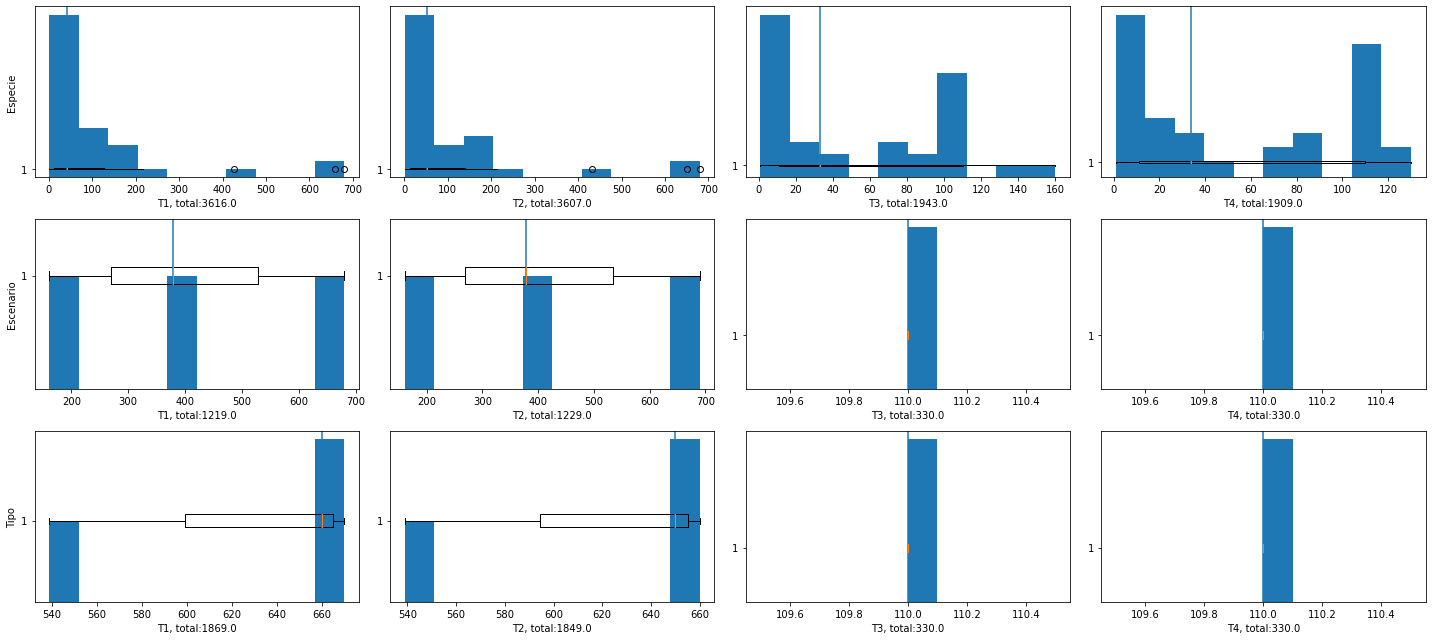

In [34]:
permutation_df = main('t4_clean.p', group_cols, quants, labels=english)

{'Especie': 240, 'Escenario': 770, 'Tipo': 760}
Especie 2444 0.39
Escenario 1228 0.69
Tipo 1757 0.56
3198 0.2
3986


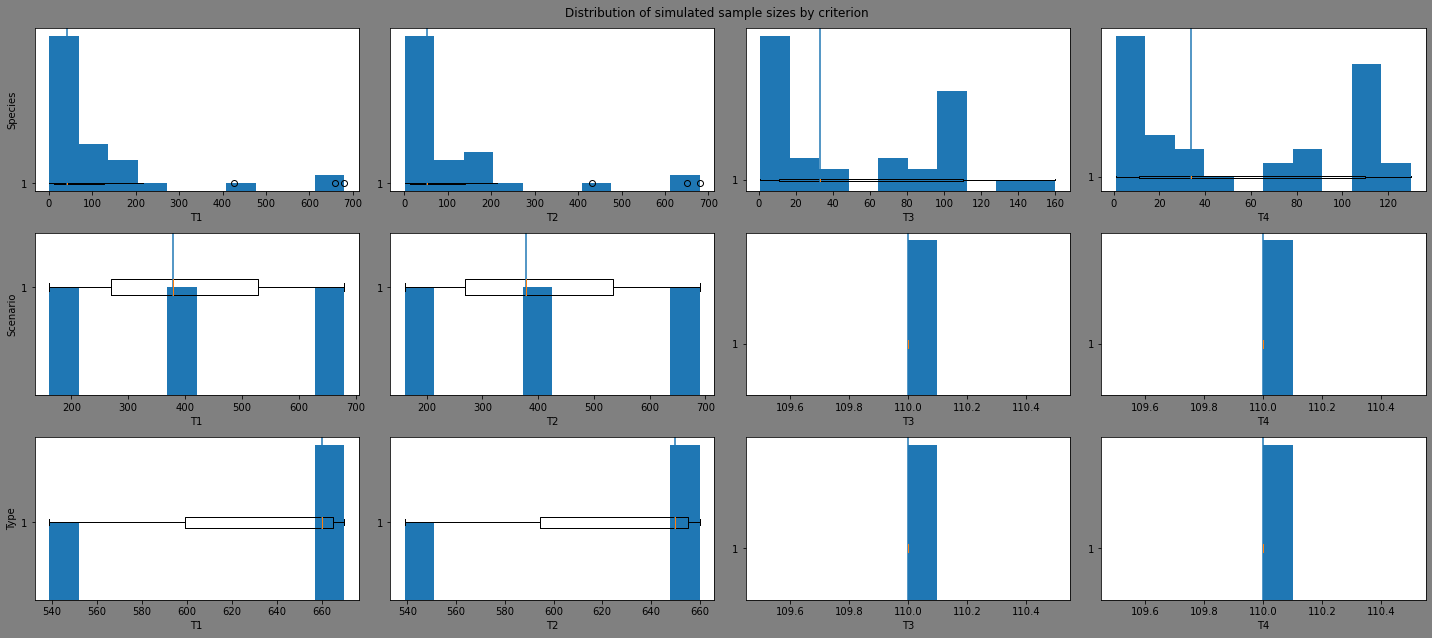

In [98]:
    df_dict, limits = calculate_improvement(permutation_df, group_cols, quants, events=events, labels=english)
    sample_list = create_sample_list(df, limits)
    final_set = set()
    pop_size = df[df['Even_mon'] == events[-1]].shape[0]
    for key in sample_list:
        print(key, len(sample_list[key]), round(1-len(sample_list[key])/pop_size, 2))
        final_set.update(sample_list[key])
    print(len(final_set), round(1-len(final_set)/pop_size, 2))
    print(pop_size)

{'Especie': 180, 'Escenario': 110, 'Tipo': 110}
Especie 2185 0.45
Escenario 281 0.93
Tipo 313 0.92
2369 0.41
3986


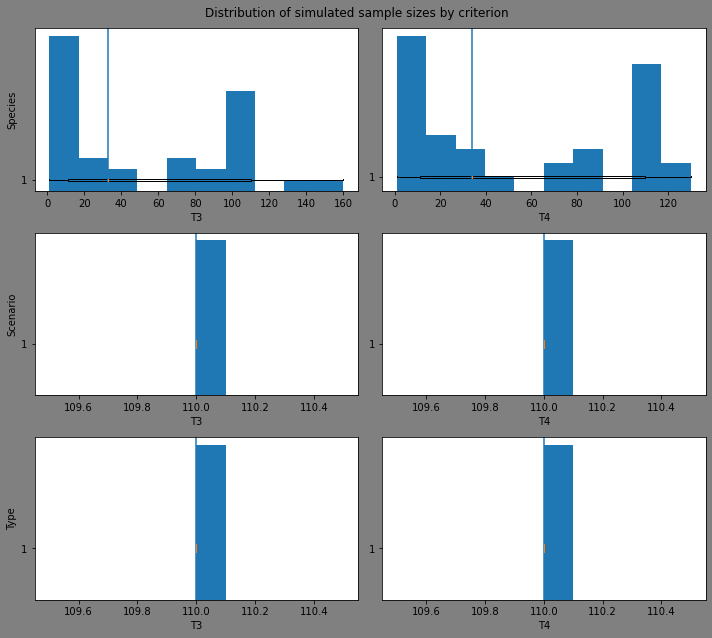

In [99]:
    df_dict, limits = calculate_improvement(permutation_df, group_cols, quants, events=['T3', 'T4'], labels=english)
    sample_list = create_sample_list(df, limits)
    final_set = set()
    pop_size = df[df['Even_mon'] == events[-1]].shape[0]
    for key in sample_list:
        print(key, len(sample_list[key]), round(1-len(sample_list[key])/pop_size, 2))
        final_set.update(sample_list[key])
    print(len(final_set), round(1-len(final_set)/pop_size, 2))
    print(pop_size)
    

In [51]:
# ANE and PNE both have too little data to simulate well so they're dropped.
sim_cols = ['Sup_Ind', 'Est_Fit', 'COL', 'VB', 'HER',
            'PAT', 'COM', 'DM', 'Alt_Ind',
            'DAB_Prom', 'Diam1_Ind', 'Diam2_Ind']
group_cols = ['Especie', 'Escenario', 'Tipo']
df = load_data('t4_clean.p')
events = df['Even_mon'].unique()
english ={'Sup_Ind':'Survival', 'Est_Fit':'Health', 'COL':'Discoloration', 'VB':'Low Vigor',
          'HER':'Herbivory', 'PAT':'Pathogens', 'COM':'Competition', 'DM':'Mechanical Damage',
          'Alt_Ind':'Height', 'DAB_Prom':'Stem Diameter', 'Diam1_Ind':'Crown 1', 'ANE':'Flooding',
          'Diam2_Ind':'Crown 2', 'Especie':'Species', 'Escenario':'Scenario', 'Tipo':'Type',
          'PNE':'Plant Not Found'}

In [52]:
plot_cols = ['Sup_Ind', 'Est_Fit', 'COL', 'VB', 'HER',
            'PAT', 'COM', 'DM', 'ANE', 'PNE', 'Alt_Ind',
            'DAB_Prom', 'Diam1_Ind', 'Diam2_Ind']

In [39]:
sub_splits = split_data(df, sim_cols, group_cols)
x_plot = []
y_plot = []
zmax = 0.065

for i in range(100):
    size = cp_smallest_sample_size(sub_splits['T1, Sup_Ind'], learning_rate=10, z_max=zmax)

    x_plot.append(zmax)
    y_plot.append(size)
    zmax += 0.001


Partitioning data...
Done!


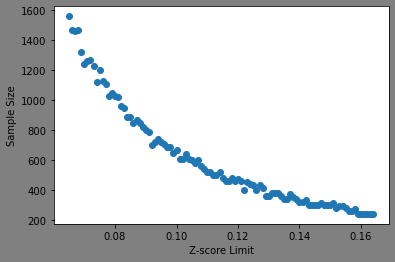

In [110]:
fig, ax = plt.subplots(1)
ax = plt.scatter(x_plot, y_plot)
plt.ylabel('Sample Size')
plt.xlabel('Z-score Limit')
fig.set_facecolor('grey')

In [51]:
subs = split_data(df, test_sim, test_group)
combined = sim_all_stats(sub_splits=subs)
test_df = dict_to_dataframes(combined, events)

Partitioning data...


[                                                                        ]   0%

Done!
Simulating...


[===================================                                     ]  49%

Creating result dict...
Done!
Converting results...


KeyError: '[2] not found in axis'

In [389]:
for split in sub_splits:
    if type(sub_splits[split]) is dict:
        for key in sub_splits[split]:
            print(split, key, sub_splits[split][key].std(), len(sub_splits[split][key]))
    else:
        print(split, sub_splits[split].std(), len(sub_splits[split]))

T1, Sup_Ind 0.18873921049555686 3975
T1, Est_Fit 1.1940234097496047 3975
T1, COL 0.20904732636424786 3975
T1, VB 0.16405466858195553 3975
T1, HER 0.4002389033757748 3975
T1, PAT 0.23728349446512098 3975
T1, COM 0.06132121123855995 3975
T1, DM 0.06897988151507498 3975
T1, ANE 0.0 3975
T1, PNE 0.12968616987639706 3975
T1, Alt_Ind 29.606605527604607 3975
T1, DAB_Prom 4.5895509507464585 3975
T1, Diam1_Ind 18.3858810194318 3975
T1, Diam2_Ind 16.65802461599687 3975
T2, Sup_Ind 0.2531619472635076 3982
T2, Est_Fit 1.2403137416844188 3982
T2, COL 0.44955103371630517 3982
T2, VB 0.08503851927751836 3982
T2, HER 0.4932722228472837 3982
T2, PAT 0.4728364900276217 3982
T2, COM 0.4122381780519724 3982
T2, DM 0.07070099353100467 3982
T2, ANE 0.07740995217677325 3982
T2, PNE 0.226527179070516 3982
T2, Alt_Ind 37.57162052198004 3982
T2, DAB_Prom 7.834636038749547 3982
T2, Diam1_Ind 32.931645408338326 3982
T2, Diam2_Ind 33.07686957117491 3982
T3, Sup_Ind 0.2581077640190431 3986
T3, Est_Fit 1.15499018201

T2, Especie, Alt_Ind Miconia sp. 26.664583251946766 3
T2, Especie, Alt_Ind Croton magdalenensis 36.334256944673236 142
T2, Especie, Alt_Ind Viburnum tinoides 27.35467932571424 84
T2, Especie, Alt_Ind Cordia cylindrostachya 11.893041849940849 13
T2, Especie, Alt_Ind Baccharis latifolia 30.04583985559926 800
T2, Especie, Alt_Ind Oreopanax incisus 16.64586568970162 198
T2, Especie, Alt_Ind Verbesina nudipes 21.119252294063763 65
T2, Especie, Alt_Ind Lippia hirsuta nan 4
T2, Especie, Alt_Ind Quercus humboldtii 18.345459770477216 84
T2, Especie, Alt_Ind Retrophyllum rospigliosii 15.046571061185361 66
T2, Especie, Alt_Ind Rhamnus goudotiana 38.540028103697146 60
T2, Especie, Alt_Ind Piper nubigenum 19.26646183719621 30
T2, Especie, Alt_Ind Hedyosmum crenatum 14.805404418657396 5
T2, Especie, Alt_Ind Weinmannia cundinamarcensis 21.21748849844906 15
T2, Especie, Alt_Ind Chamaedorea linearis 13.121391632267779 51
T2, Especie, Alt_Ind Bocconia frutescens 26.669444299783585 30
T2, Especie, Alt_In

In [67]:
del sub_splits
del combined
del permutation_df
del loose_combined
del loose_permutation_df

NameError: name 'sub_splits' is not defined

In [76]:
# TODO: Cast df['Area_cop_Ind'] as 'float64' instead of 'Float64'
sub_splits = split_data(df, sim_cols, group_cols)
combined = sim_all_stats(sub_splits)
permutation_df = dict_to_dataframes(combined, events)

Partitioning data...


[                                                                        ]   0%

Done!
Simulating...


[========================================================================] 100%

Creating result dict...
Done!
Converting results...
Done!


In [75]:
loose_combined = sim_all_stats(sub_splits, conf=0.95)
loose_permutation_df = dict_to_dataframes(loose_combined, events)

[                                                                        ]   0%

Simulating...


[========================================================================] 100%

Creating result dict...
Done!
Converting results...
Done!


In [77]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

tight = permutation_df.select_dtypes(include=numerics)
loose = loose_permutation_df.select_dtypes(include=numerics)
diffs = tight - loose
diffs

,old Est_Fit,old Sup_Ind,old PNE,old DAB_Prom,old HER,new Diam2_Ind,old COL,old COM,old Alt_Ind,new DM,new Sup_Ind,old DM,new Alt_Ind,new Diam1_Ind,new HER,old VB,new DAB_Prom,old Diam2_Ind,old ANE,new PAT,new COL,new ANE,new Est_Fit,new PNE,old Diam1_Ind,new COM,new VB,old PAT
T1 Escenario Pastos limpios,0,0,0,0,0,0,0,0,0,330,310,0,0,0,290,0,270,0,0,210,270,0,310,340,0,390,260,0
T1 Escenario Veg. secundaria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T1 Escenario Bosque,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,118,0,0
T2 Escenario Veg. secundaria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T2 Escenario Pastos limpios,0,0,0,0,0,0,0,0,0,400,270,0,0,0,260,0,250,0,0,250,290,320,260,290,0,260,410,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T3 Tipo 0,0,0,0,0,0,0,0,0,0,299,149,0,0,0,149,0,0,0,0,149,149,0,139,0,0,139,329,0
T3 Tipo 1,0,0,0,0,0,0,0,0,0,350,250,0,0,0,270,0,0,0,0,250,270,0,260,470,0,260,320,0
T1,0,0,0,0,0,0,0,0,0,340,290,0,0,0,230,0,260,0,0,250,270,0,260,270,0,500,260,0
T2,0,0,0,0,0,0,0,0,0,420,260,0,0,0,270,0,260,0,0,270,260,440,260,230,0,240,380,0


In [494]:
reds = diffs.loc[(diffs != 0).any(axis=1), (diffs != 0).any(axis=0)]

{'whiskers': [<matplotlib.lines.Line2D at 0x1823934ec40>,
 'caps': [<matplotlib.lines.Line2D at 0x18232336220>,
 'boxes': [<matplotlib.lines.Line2D at 0x1823934e970>],
 'medians': [<matplotlib.lines.Line2D at 0x182323367c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18232336a90>],
 'means': []}

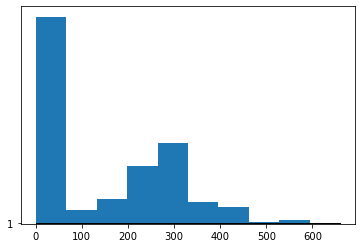

In [497]:
reds = diffs.loc[(diffs != 0).any(axis=1), (diffs != 0).any(axis=0)]
reds = pd.concat([reds[col] for col in reds])
plt.hist(reds)
plt.boxplot(reds, vert=False)


Partitioning data...


[                                                                        ]   0%

Done!
Simulating...


[========================================================================] 100%

Creating result dict...
Done!
Converting results...
Done!
{'Especie': 210, 'Escenario': 2200, 'Tipo': 2480}
Especie 2376 0.4
Escenario 2142 0.46
Tipo 3986 0.0
3986 0.0
3986


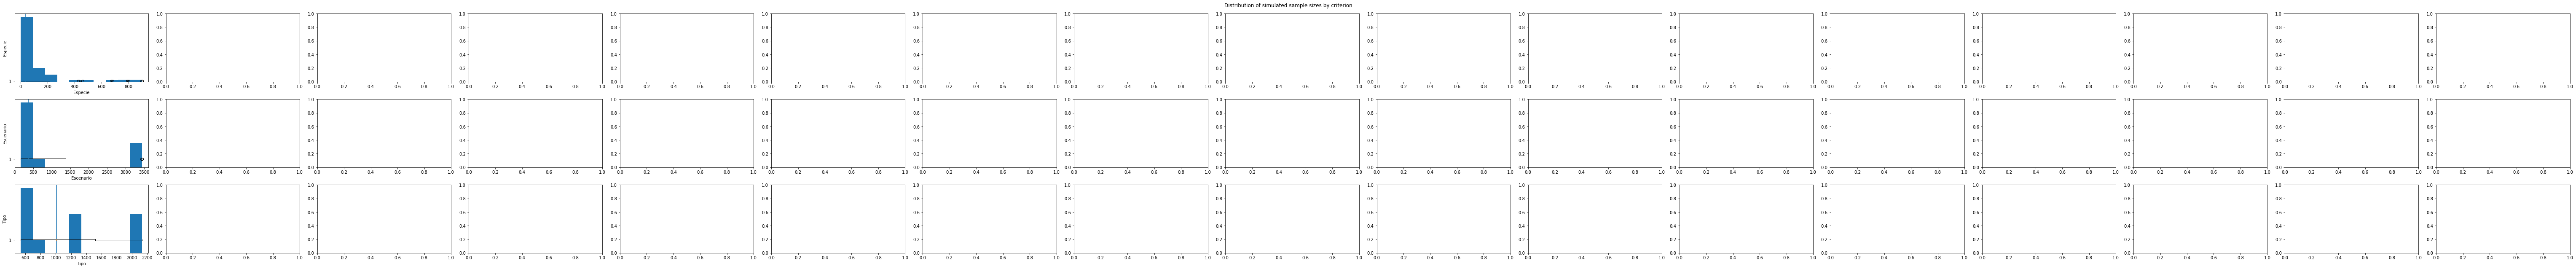

In [55]:
for_plot = main('t4_clean.p', group_cols, plot_cols, labels=english)

In [56]:
for_plot

,new DM,old DM,old Diam2_Ind,old Sup_Ind,new COL,old PAT,new Diam1_Ind,new COM,old DAB_Prom,new HER,...,new Diam2_Ind,old HER,new Sup_Ind,old Diam1_Ind,old Est_Fit,new Alt_Ind,new ANE,new VB,time,group
T1 Escenario Pastos limpios,590,3436,3436,3436,650,3436,110,580,3436,640,...,110,3436,640,3436,3436,110,3436,620,T1,Escenario
T1 Escenario Bosque,378,378,378,378,378,378,110,378,378,378,...,110,378,378,378,378,110,378,378,T1,Escenario
T1 Escenario Veg. secundaria,161,161,161,161,161,161,110,161,161,161,...,110,161,161,161,161,110,161,161,T1,Escenario
T2 Escenario Pastos limpios,650,3443,3443,3443,650,3443,110,660,3443,680,...,110,3443,660,3443,3443,110,590,590,T2,Escenario
T2 Escenario Veg. secundaria,161,161,161,161,161,161,161,161,161,161,...,161,161,161,161,161,161,161,161,T2,Escenario
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T4 Tipo 1,590,1313,1313,1313,640,1313,110,660,1313,630,...,110,1313,660,1313,1313,110,1313,660,T4,Tipo
T1,600,3975,3975,3975,630,3975,110,610,3975,650,...,110,3975,650,3975,3975,110,3975,620,T1,None
T2,580,3982,3982,3982,690,3982,110,660,3982,640,...,110,3982,660,3982,3982,110,600,640,T2,None
T3,610,3983,3983,3983,660,3983,110,620,3983,670,...,110,3983,660,3983,3983,110,3983,640,T3,None


In [66]:
for_plot[for_plot['group'].isnull() == True]

,new DM,old DM,old Diam2_Ind,old Sup_Ind,new COL,old PAT,new Diam1_Ind,new COM,old DAB_Prom,new HER,...,new Diam2_Ind,old HER,new Sup_Ind,old Diam1_Ind,old Est_Fit,new Alt_Ind,new ANE,new VB,time,group
T1,600,3975,3975,3975,630,3975,110,610,3975,650,...,110,3975,650,3975,3975,110,3975,620,T1,None
T2,580,3982,3982,3982,690,3982,110,660,3982,640,...,110,3982,660,3982,3982,110,600,640,T2,None
T3,610,3983,3983,3983,660,3983,110,620,3983,670,...,110,3983,660,3983,3983,110,3983,640,T3,None
T4,620,3986,3986,3986,680,3986,110,650,3986,640,...,110,3986,650,3986,3986,110,3986,610,T4,None


In [122]:
def plot_grouping(grouping, df=permutation_df, sim_cols=sim_cols, labels=english):
    ''' Plots all the previously simulated groupings in permutation_df.
    INPUTS:
    grouping: (str) containing the value of the 'group' column in the dataframe.
    df: (DataFrame) contains old and new simulated values for population size
    desired_stats: (list-like) act as columns, typically just 'mean' and 'std'
    sim_cols: (list-like) act as rows, the various factors simulated from the original dataframe.
    OUTPUT: a matplotlib chart of the various arrangements specified. Interpretation is up to the user.
    '''
    if grouping == 'None':
        data = df[df['group'].isnull() == True]
    else:
        data = df[df['group'] == grouping]
        
    index = data.index    
    fig, ax = plt.subplots(nrows=len(sim_cols), ncols=1, figsize=(6, 3*len(sim_cols)))
    #ax[0].set_title(f'Sample size improvements for metrics grouped by {labels[grouping]}')
    row = 0
    for sim in sim_cols:
        label = labels[sim]
        for var in ['old', 'new']:
            key = f'{var} {sim}'
            ax[row].bar(x=index, height=data[key])
        ax[row].set_ylabel(f'{label}')
        ax[row].set_xticks(index)
        ax[row].set_xticklabels([])
        row += 1
    ax[0].legend(['Improvement over Old Sample', 'New Sample Size'])
    fig.set_facecolor('grey')

    fig.tight_layout()

KeyError: 'None'

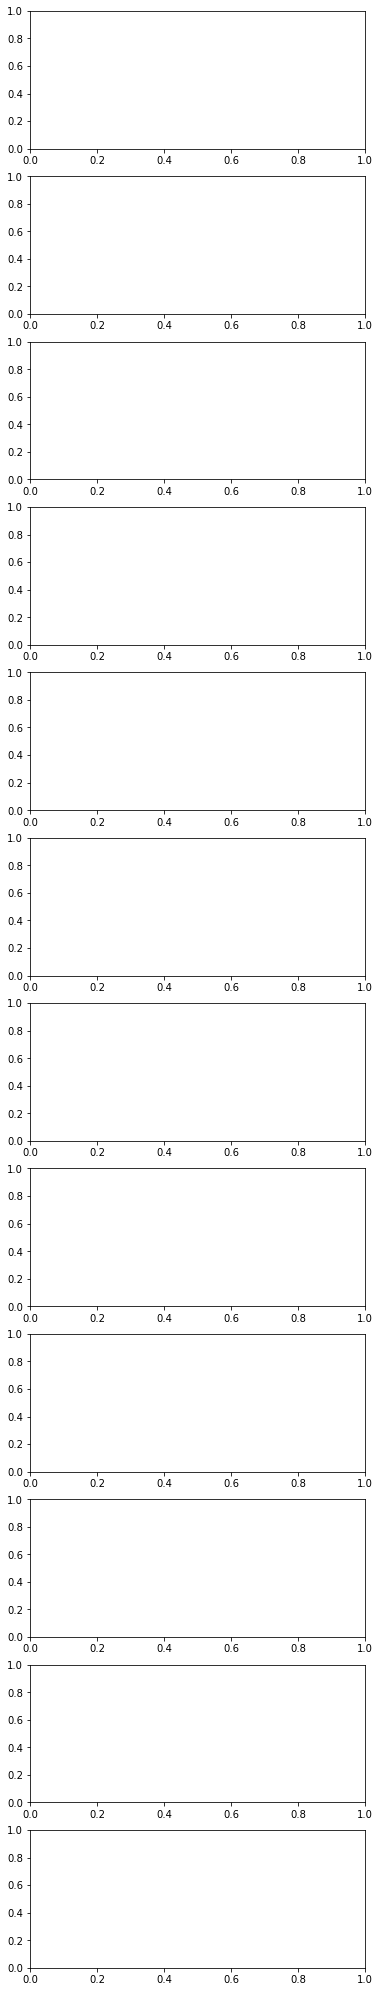

In [112]:
plot_grouping('None', df=for_plot)

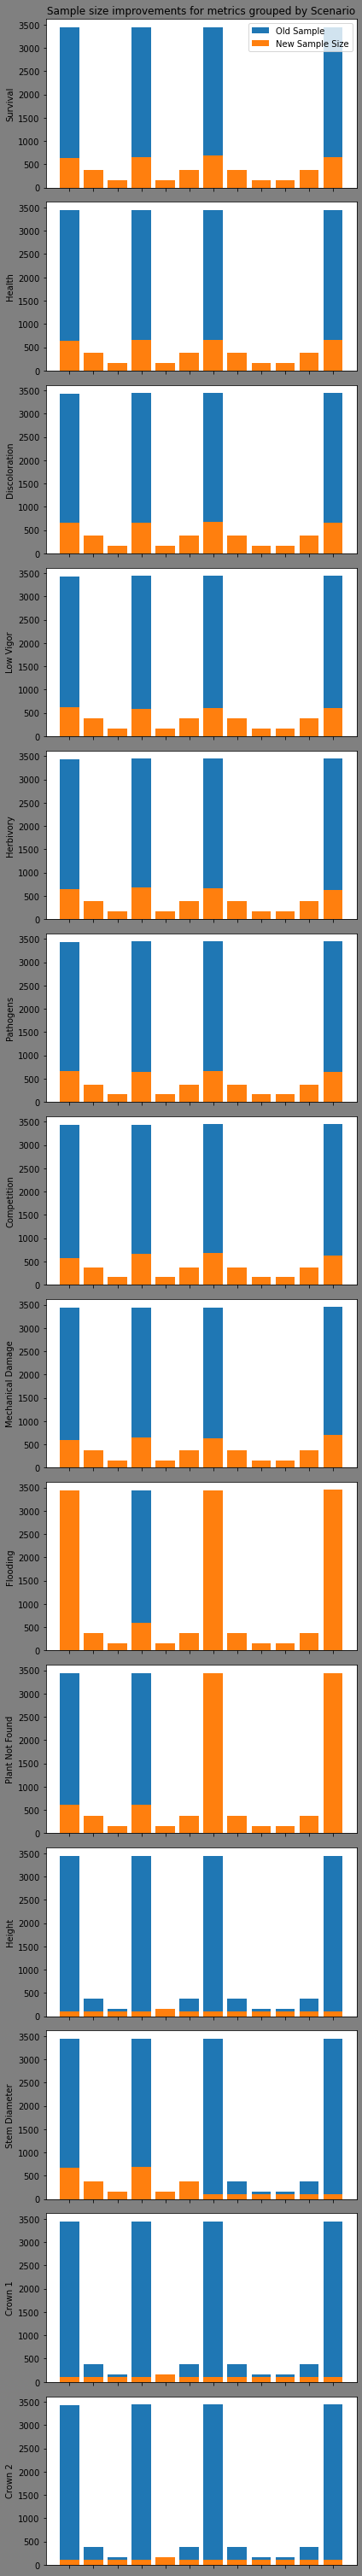

In [117]:
plot_grouping('Escenario', df=for_plot, sim_cols=plot_cols) # Por tipo de nucleo

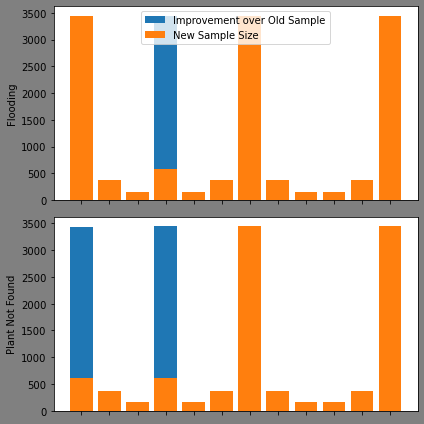

In [123]:
plot_grouping('Escenario', df=for_plot, sim_cols=['ANE', 'PNE'])

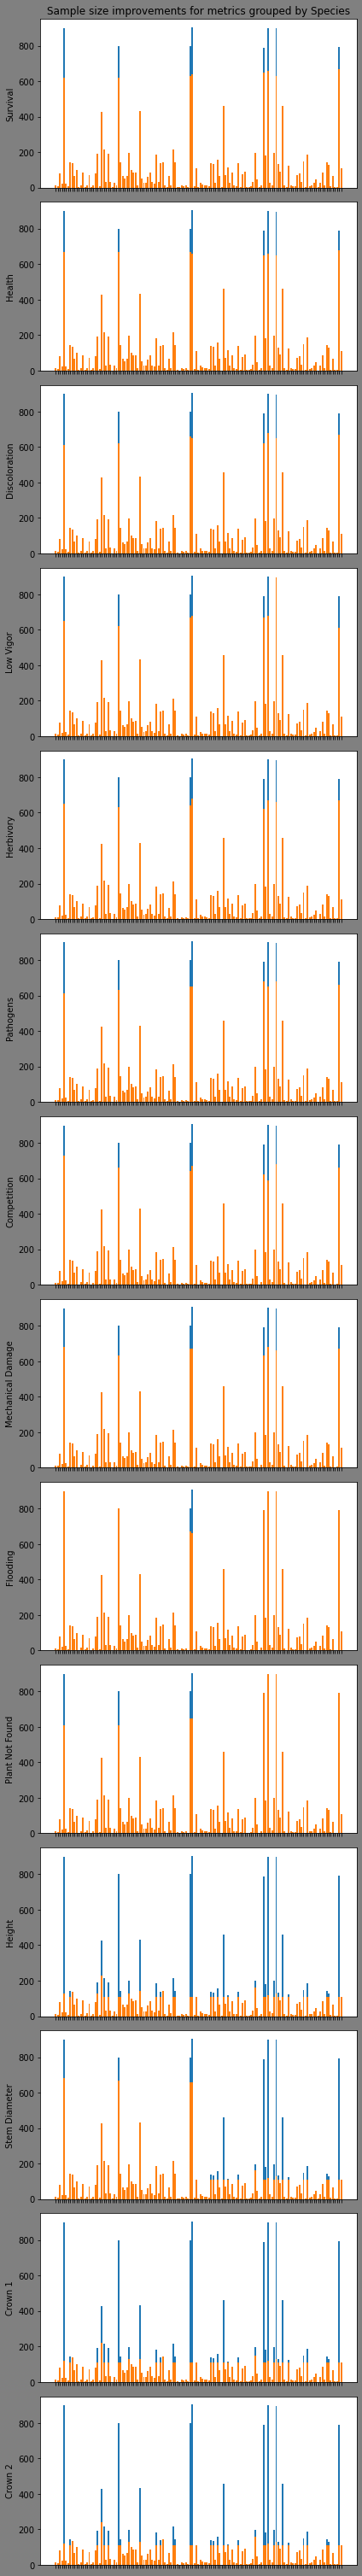

In [93]:
plot_grouping('Especie', df=for_plot, sim_cols=plot_cols)

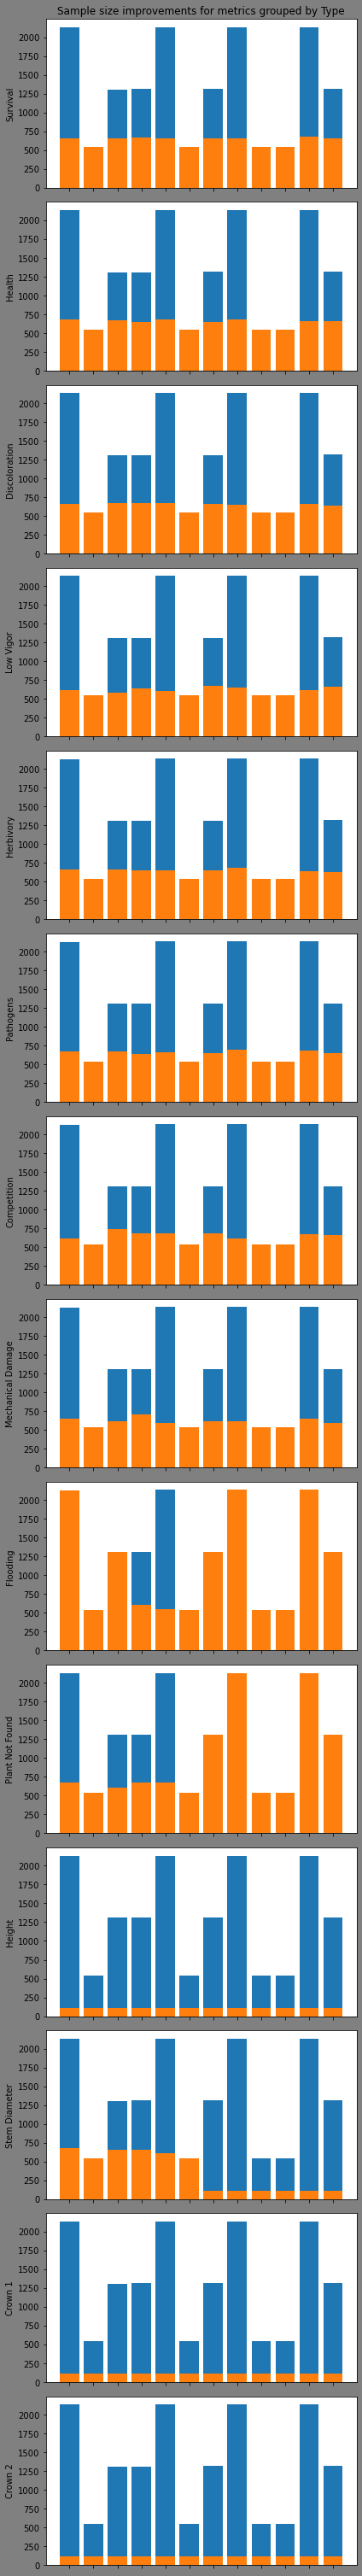

In [94]:
plot_grouping('Tipo', df=for_plot, sim_cols=plot_cols)

In [318]:
new_cols = []
old_cols = []
for col in permutation_df.columns:
    if 'old' in col:
        old_cols.append(col)
    if 'new' in col:
        new_cols.append(col)
new_cols

['new Diam2_Ind',
 'new DM',
 'new Sup_Ind',
 'new Alt_Ind',
 'new Diam1_Ind',
 'new HER',
 'new DAB_Prom',
 'new PAT',
 'new COL',
 'new ANE',
 'new Est_Fit',
 'new PNE',
 'new COM',
 'new VB']

In [210]:
improvement = pd.DataFrame()
for col in sim_cols:
    old = permutation_df[f'old {col}']
    new = permutation_df[f'new {col}']
    improvement[col] = old-new
improvement

,Sup_Ind,Est_Fit,COL,VB,HER,PAT,COM,DM,ANE,PNE,Alt_Ind,DAB_Prom,Diam1_Ind,Diam2_Ind
T1 Escenario Pastos limpios,2796,2756,2786,2816,2766,2806,2756,2846,0,2826,3326,2776,3326,3326
T1 Escenario Veg. secundaria,0,0,0,0,0,0,0,0,0,0,51,0,51,51
T1 Escenario Bosque,0,0,0,0,0,0,0,0,0,0,268,0,268,268
T2 Escenario Veg. secundaria,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T2 Escenario Pastos limpios,2803,2793,2773,2793,2773,2783,2793,2793,2853,2783,3333,2793,3333,3333
T2 Escenario Bosque,0,0,0,0,0,0,0,0,0,0,268,0,268,268
T3 Escenario Pastos limpios,2767,2777,2797,2847,2807,2757,2837,2827,0,2677,3337,3337,3337,3337
T3 Escenario Veg. secundaria,0,0,0,0,0,0,0,0,0,0,51,51,51,51
T3 Escenario Bosque,0,0,0,0,0,0,0,0,0,0,268,268,268,268
T1 Especie Smallanthus pyramidalis,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
# the max value of all the 'new' columns gives us the absolute largest sample size
# to capture the entire statistical variation of the population. 
# This is 640 for the standard deviation of basal stem diameter.
# It's probably more practical to pick an intermediate value, like 200, and then sample
# the extra stats more thoroughly if there's a practical reason to do so.
print(permutation_df.shape)
permutation_df.describe().loc['max'].sort_index().loc[new_cols].sort_values()

(123, 30)


new Alt_Ind       220.0
new Diam1_Ind     220.0
new Diam2_Ind     230.0
new DAB_Prom      680.0
new COL           680.0
new VB            680.0
new PAT           690.0
new Est_Fit       690.0
new Sup_Ind       700.0
new HER           700.0
new DM            710.0
new COM           740.0
new PNE           900.0
new ANE          3986.0
Name: max, dtype: float64

In [113]:
loose_permutation_df.describe().loc['max'].sort_index().loc[new_cols].sort_values()

new Diam2_Ind     161.0
new Alt_Ind       161.0
new Diam1_Ind     161.0
new DM            378.0
new Est_Fit       400.0
new Sup_Ind       410.0
new HER           410.0
new DAB_Prom      410.0
new COL           410.0
new PAT           420.0
new COM           426.0
new VB            431.0
new PNE           900.0
new ANE          3986.0
Name: max, dtype: float64

Average improvement for Especie: 20.27%
Average improvement for Escenario: 75.53%
Average improvement for Tipo: 63.31%
{'Especie': 240, 'Escenario': 830, 'Tipo': 880}


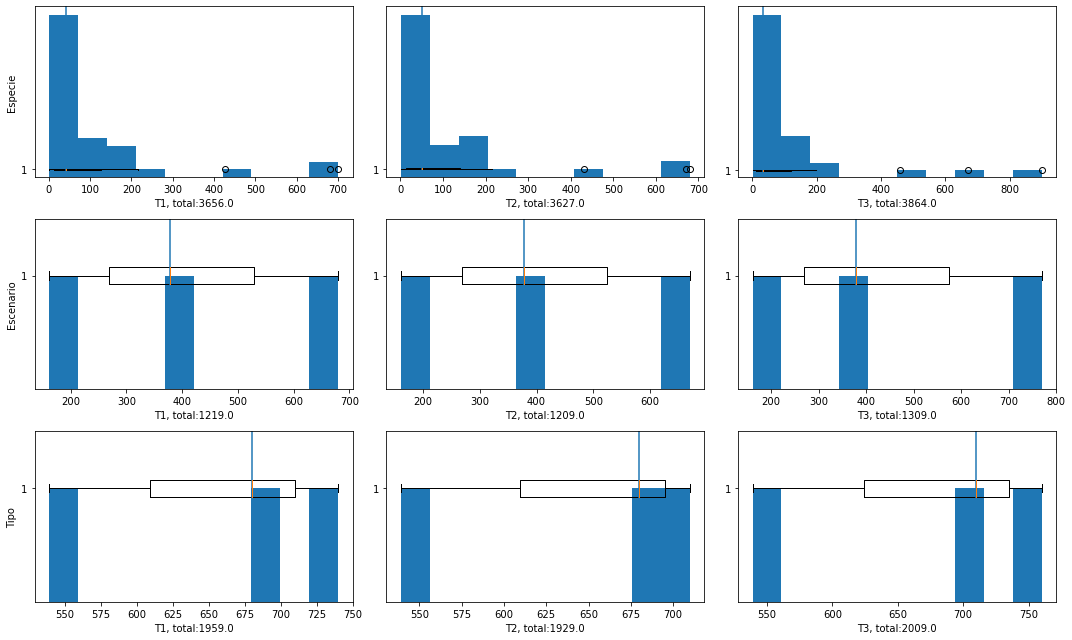

In [332]:
sub_sims = sim_cols

test, limits = calculate_improvement(permutation_df, group_cols=group_cols, sim_cols=sub_sims)

{'Especie': 240, 'Escenario': 750, 'Tipo': 740}
Especie 2445
Escenario 1226
Tipo 1750
3182
3983


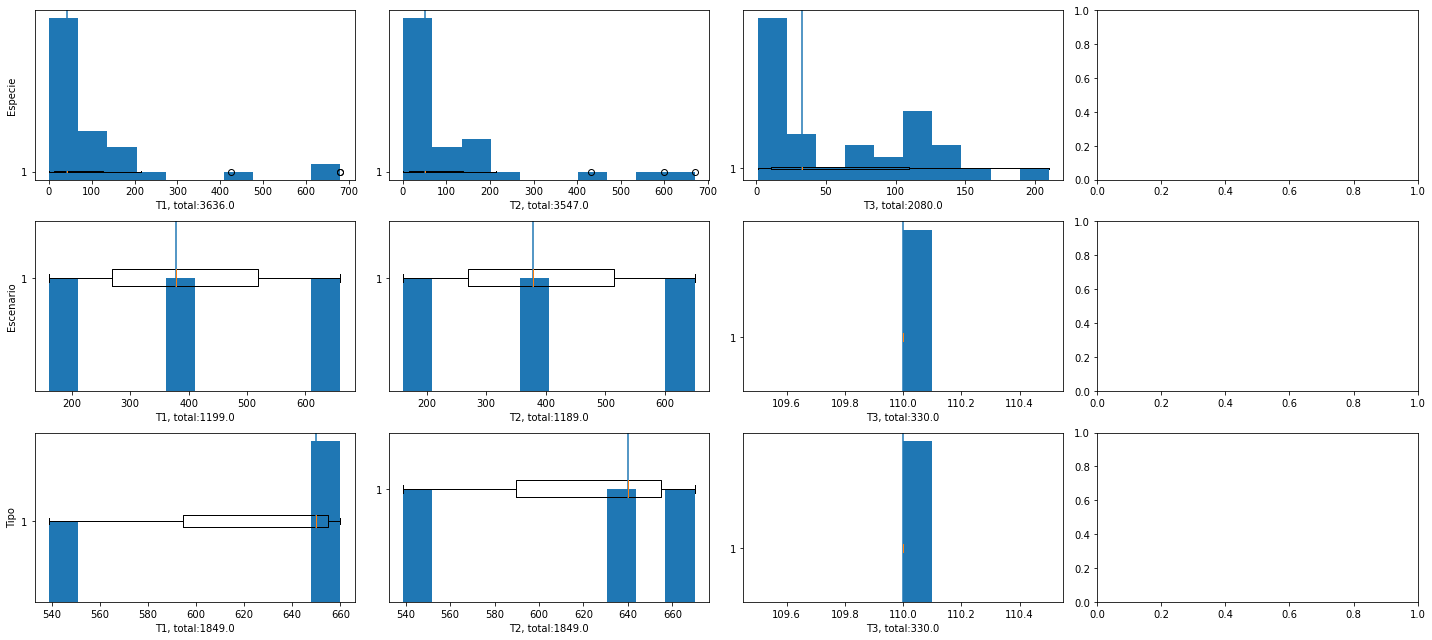

In [23]:
quants = ['Alt_Ind', 'DAB_Prom', 'Diam1_Ind', 'Diam2_Ind']


q_dict, q_lim = calculate_improvement(permutation_df, group_cols=group_cols, sim_cols=quants, events=events)

sample_list = create_sample_list(df, q_lim)
final_set = set()
for key in sample_list:
    print(key, len(sample_list[key]))
    final_set.update(sample_list[key])
print(len(final_set))
print(df[df['Even_mon'] == 'T3'].shape[0])

In [493]:
sample_list = create_sample_list(df, limits)
final_set = set()
pop_size = dft4[dft4['Even_mon'] == 'T4'].shape[0]
for key in sample_list:
    print(key, len(sample_list[key]), round(1-len(sample_list[key])/pop_size, 2))
    final_set.update(sample_list[key])
print(len(final_set), round(1-len(final_set)/pop_size, 2))
print(pop_size)

Especie 2440 0.39
Escenario 1270 0.68
Tipo 1886 0.53
3237 0.19
3986


In [388]:
# On the other hand, examining how this applies on average shows that 640 is an outlier.
permutation_df['new DAB_Prom'].describe()

count    123.000000
mean     141.536585
std      197.237366
min        1.000000
25%       14.000000
50%       69.000000
75%      142.000000
max      680.000000
Name: new DAB_Prom, dtype: float64

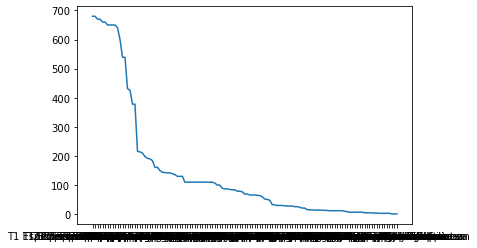

In [389]:
plt.plot(permutation_df['new DAB_Prom'].sort_values(ascending=False))

In [101]:
#If anything it would be more efficient to treat the edge cases with special consideration.
permutation_df.sort_values('new DAB_Prom', ascending=False).head(20)

,old Est_Fit,old Sup_Ind,old PNE,old DAB_Prom,old HER,new Diam2_Ind,old COL,old COM,old Alt_Ind,new DM,new Sup_Ind,old DM,new Alt_Ind,new Diam1_Ind,new HER,old VB,new DAB_Prom,old Diam2_Ind,old ANE,new PAT,new COL,new ANE,new Est_Fit,new PNE,old Diam1_Ind,new COM,new VB,old PAT,time,group
T1 Especie Verbesina crassiramea,899,899,899,899,899,120,899,899,899,680,650,899,140,110,660,899,680,899,899,630,650,899,640,650,899,580,650,899,T1,Especie
T1 Especie Baccharis latifolia,800,800,800,800,800,110,800,800,800,630,670,800,110,110,700,800,680,800,800,640,670,800,650,610,800,660,620,800,T1,Especie
T2 Tipo 1,1309,1309,1309,1309,1309,110,1309,1309,1309,710,700,1309,110,110,680,1309,670,1309,1309,660,650,610,660,670,1309,630,630,1309,T2,Tipo
T2 Especie Baccharis latifolia,800,800,800,800,800,110,800,800,800,670,660,800,110,110,660,800,670,800,800,630,660,670,660,660,800,650,670,800,T2,Especie
T1 Escenario Pastos limpios,3436,3436,3436,3436,3436,110,3436,3436,3436,590,640,3436,110,110,670,3436,660,3436,3436,630,650,3436,680,610,3436,680,620,3436,T1,Escenario
T1 Tipo 2,2129,2129,2129,2129,2129,110,2129,2129,2129,650,670,2129,110,110,660,2129,660,2129,2129,670,650,2129,680,560,2129,610,620,2129,T1,Tipo
T2 Escenario Pastos limpios,3443,3443,3443,3443,3443,110,3443,3443,3443,650,640,3443,110,110,670,3443,650,3443,3443,660,670,590,650,660,3443,650,650,3443,T2,Escenario
T1 Tipo 1,1307,1307,1307,1307,1307,110,1307,1307,1307,530,640,1307,110,110,660,1307,650,1307,1307,670,650,1307,660,650,1307,740,660,1307,T1,Tipo
T2,3982,3982,3982,3982,3982,110,3982,3982,3982,670,650,3982,110,110,660,3982,650,3982,3982,670,660,660,650,630,3982,640,640,3982,T2,None
T1,3975,3975,3975,3975,3975,110,3975,3975,3975,600,650,3975,110,110,630,3975,650,3975,3975,650,630,3975,660,640,3975,710,650,3975,T1,None


In [97]:
df[(df['Especie'] == 'Baccharis latifolia') & (df['Sup_Ind'] == 1)]['DAB_Prom'].describe()

count    2276.000000
mean       13.536028
std         7.677856
min         0.000000
25%         8.000000
50%        12.000000
75%        18.000000
max       106.000000
Name: DAB_Prom, dtype: float64

In [98]:
pd.set_option("display.max_rows", None)
df[(df['Especie'] == 'Baccharis latifolia') & (df['Sup_Ind'] == 1)][['ID','Even_mon','DAB_Prom']].sort_values('DAB_Prom')

,ID,Even_mon,DAB_Prom
34,35,T1,0.0
70,71,T1,0.0
107,108,T1,0.0
1578,1579,T1,0.0
1582,1583,T1,0.0
291,292,T1,0.0
2509,2510,T1,0.0
2518,2519,T1,0.0
1946,1947,T1,0.0
2025,2026,T1,0.0


(array([ 44., 457., 528., 290., 102.,  59.,  33.,   9.,   2.,   1.,   1.,
          0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ,
        41.8, 45.6, 49.4, 53.2, 57. , 60.8, 64.6, 68.4, 72.2, 76. ]),
 <BarContainer object of 20 artists>)

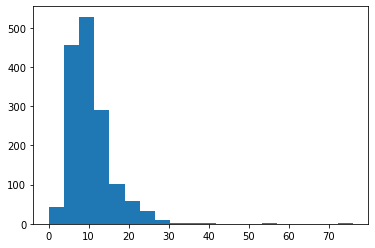

In [346]:
# It's actually strange that the standard deviation is so hard to capture, the distribution seems quite normal.
plt.hist(df[(df['Especie'] == 'Baccharis latifolia') & (df['Sup_Ind'] == 1) & (df['Even_mon'] != 'T3')]['DAB_Prom'], bins=20)

In [362]:
import time
np_start = time.perf_counter()
counter = 0
while counter < 1:
    pop = get_smallest_sample_size(sub_splits['T1, Sup_Ind'], learning_rate=10, z_max=0.065)
    counter += 1
np_end = time.perf_counter()
print(pop)
print(f"time for np: {np_end-np_start:0.4f} seconds")

cp_start = time.perf_counter()
counter = 0
while counter < 1:
    pop = cp_smallest_sample_size(sub_splits['T1, Sup_Ind'], learning_rate=10, z_max=0.065)
    counter += 1
cp_end = time.perf_counter()
print(pop)
print(f"time for cp: {cp_end-cp_start:0.4f} seconds")


910
time for np: 22.7311 seconds
920
time for cp: 5.6829 seconds


In [99]:
# Save data
permutation_df.to_pickle('tight.p')
loose_permutation_df.to_pickle('loose.p')

In [306]:
for col in bin_cols:
    print(df[col].value_counts())


0.0    10110
1.0     1833
Name: COL, dtype: int64
0.0    11771
1.0      172
Name: VB, dtype: int64
1.0    6196
0.0    5747
Name: HER, dtype: int64
1.0    6339
0.0    5604
Name: PAT, dtype: int64
0.0    10685
1.0     1258
Name: COM, dtype: int64
0.0    11885
1.0       58
Name: DM, dtype: int64
0.0    11919
1.0       24
Name: ANE, dtype: int64
0.0    11654
1.0      289
Name: PNE, dtype: int64


In [304]:
bin_cols = ['COL', 'VB', 'HER', 'PAT', 'COM', 'DM', 'ANE', 'PNE']

Partitioning data...


[                                                                        ]   0%

Done!
Simulating...


[======================================================================= ]  98%

Creating result dict...
Done!
Converting results...
Done!
Average improvement for Especie: 20.58%
Average improvement for Escenario: 73.22%
Average improvement for Tipo: 61.87%
{'Especie': 240, 'Escenario': 2840, 'Tipo': 2510}
Especie 2428
Escenario 2455
Tipo 3986
3986
0


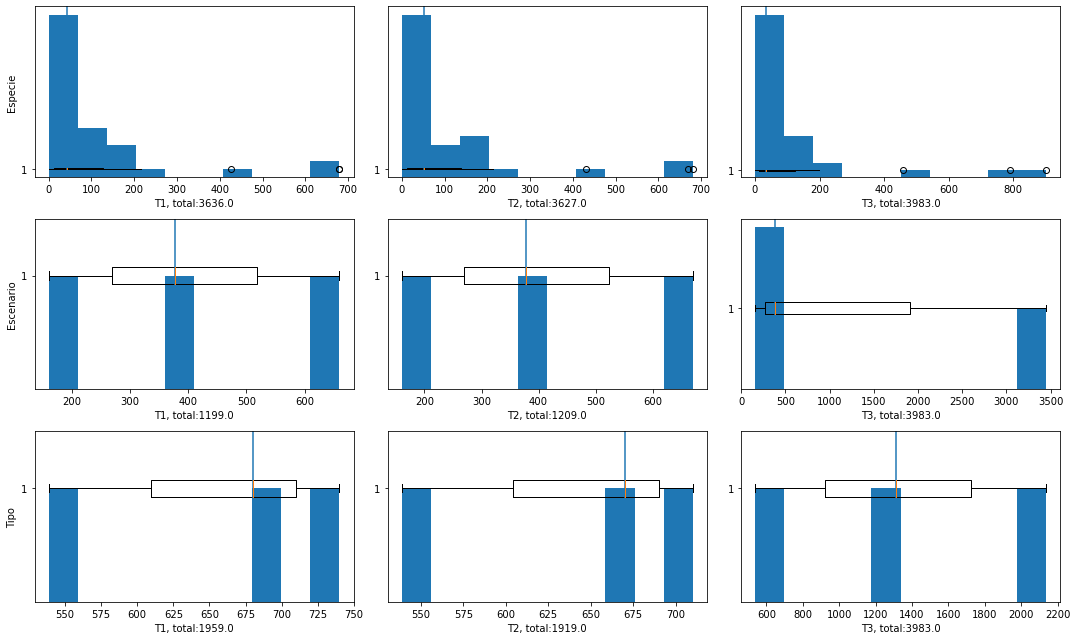

In [473]:
t4_ev = dft4['Even_mon'].unique()
t4_s = split_data(dft4, sim_cols, group_cols)
t4_c = sim_all_stats(sub_splits=t4_s)
t4_df = dict_to_dataframes(t4_c, t4_ev)
t4_test, t4_lim = calculate_improvement(t4_df, group_cols=group_cols, sim_cols=sub_sims)
sample_list = create_sample_list(dft4, t4_lim)
final_set = set()
pop_size = dft4[dft4['Even_mon'] == 'T4'].shape[0]
for key in sample_list:
    print(key, len(sample_list[key]), round(1-len(sample_list[key])/pop_size, 2))
    final_set.update(sample_list[key])
print(len(final_set), round(1-len(final_set)/pop_size, 2))
print(pop_size)

Average improvement for Especie: 21.85%
Average improvement for Escenario: 76.39%
Average improvement for Tipo: 64.8%
{'Especie': 240, 'Escenario': 770, 'Tipo': 830}


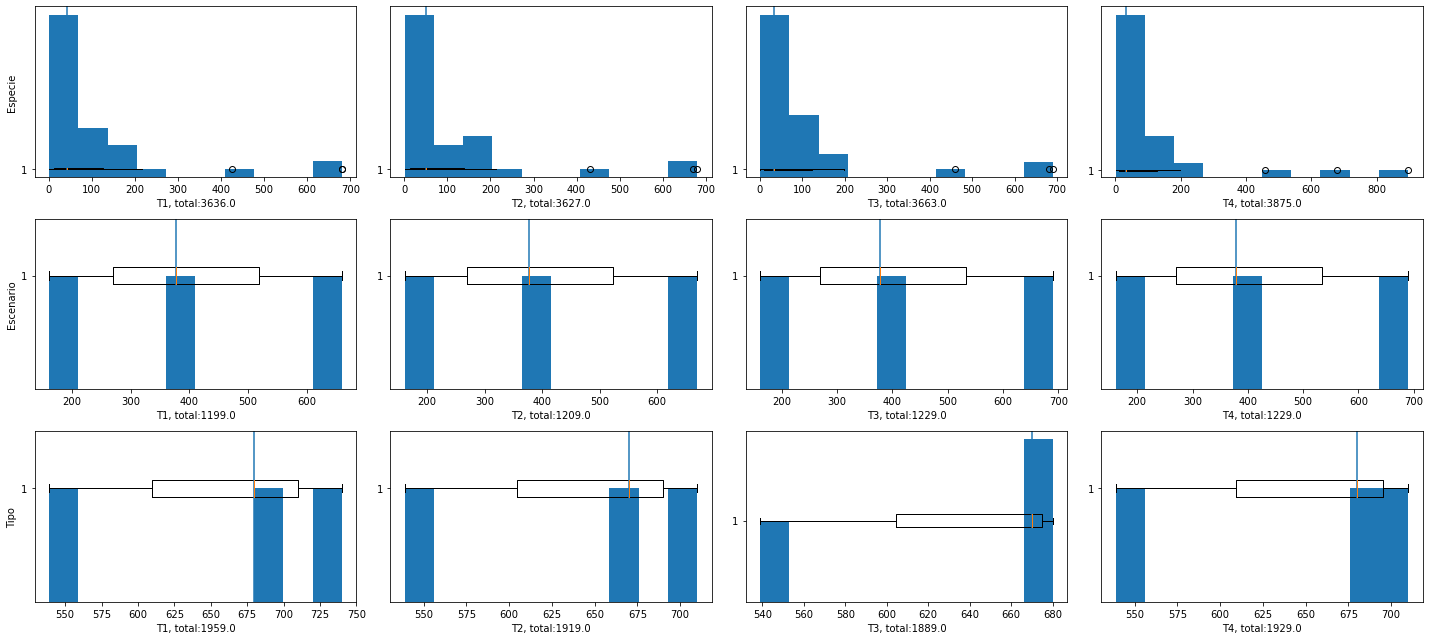

In [483]:
sub_sims.remove('PNE')
t4_test, t4_lim = calculate_improvement(t4_df, group_cols=group_cols, sim_cols=sub_sims, events=t4_ev)

Average improvement for Especie: 21.85%
Average improvement for Escenario: 76.39%
Average improvement for Tipo: 64.8%
{'Especie': 210, 'Escenario': 770, 'Tipo': 810}


({'Especie':                                         old Sup_Ind  old Est_Fit  old COL  \
  T1 Especie Smallanthus pyramidalis               24           24       24   
  T1 Especie Verbesina nudipes                     69           69       69   
  T1 Especie Cedrela montana                       87           87       87   
  T1 Especie Brunellia comocladifolia               7            7        7   
  T1 Especie Axinaea sp.                           12           12       12   
  T1 Especie Chamaedorea linearis                  52           52       52   
  T1 Especie Hedyosmum crenatum                     5            5        5   
  T1 Especie Myrcianthes leucoxyla                 28           28       28   
  T1 Especie Ageratina boyacensis                 136          136      136   
  T1 Especie Solanum oblongifolium                426          426      426   
  T1 Especie Croton magdalenensis                 142          142      142   
  T1 Especie Morella pubescens           

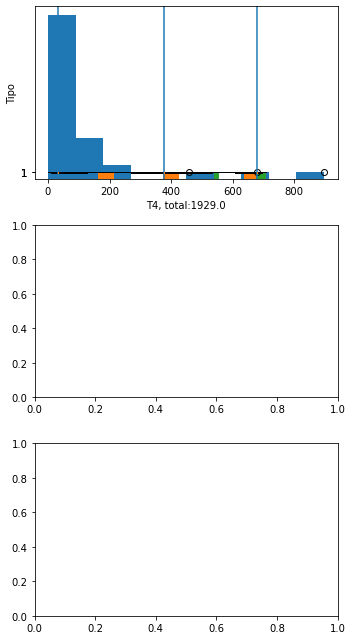

In [484]:
calculate_improvement(t4_df, group_cols=group_cols, sim_cols=sub_sims, events=['T4'])

In [492]:
sample_list = create_sample_list(dft4, t4_lim)
final_set = set()
pop_size = dft4[dft4['Even_mon'] == 'T4'].shape[0]
for key in sample_list:
    print(key, len(sample_list[key]), round(1-len(sample_list[key])/pop_size, 2))
    final_set.update(sample_list[key])
print(len(final_set), round(1-len(final_set)/pop_size, 2))
print(pop_size)

Especie 2433 0.39
Escenario 1236 0.69
Tipo 1842 0.54
3199 0.2
3986


In [488]:
df['Even_mon']

0        T1
1        T1
2        T1
3        T1
4        T1
5        T1
6        T1
7        T1
8        T1
9        T1
10       T1
11       T1
12       T1
13       T1
14       T1
15       T1
16       T1
17       T1
18       T1
19       T1
20       T1
21       T1
22       T1
23       T1
24       T1
25       T1
26       T1
27       T1
28       T1
29       T1
30       T1
31       T1
32       T1
33       T1
34       T1
35       T1
36       T1
37       T1
38       T1
39       T1
40       T1
41       T1
42       T1
43       T1
44       T1
45       T1
46       T1
47       T1
48       T1
49       T1
50       T1
51       T1
52       T1
53       T1
54       T1
55       T1
56       T1
57       T1
58       T1
59       T1
60       T1
61       T1
62       T1
63       T1
64       T1
65       T1
66       T1
67       T1
68       T1
69       T1
70       T1
71       T1
72       T1
73       T1
74       T1
75       T1
76       T1
77       T1
78       T1
79       T1
80       T1
81       T1
82       T1
83  

In [463]:
for col in dft4.columns:
    print(col)
    try:
        if dft4[col].dtype == 'Int64':
            dft4[col] = dft4[col].astype('int64')
        elif dft4[col].dtype == 'Float64':
            dft4[col] = dft4[col].astype('float64')
    except:
        print('e')
dft4.dtypes

Fecha
Even_mon
ID
Especie
Escenario
Estrategia
Tipo
No_Nuc/Faj/Mod
Línea
e
No_Ind
Sup_Ind
Est_Fit
COL
VB
HER
PAT
COM
DM
ANE
PNE
Alt_Ind
DAB1_Ind
DAB2_Ind
e
DAB_Prom
Diam1_Ind
e
Diam2_Ind
Area_cop_Ind
Observaciones
est_0
est_1
est_2
est_3
est_4


Fecha              object
Even_mon           string
ID                  int64
Especie            string
Escenario          string
Estrategia         string
Tipo                int64
No_Nuc/Faj/Mod      int64
Línea               Int64
No_Ind              int64
Sup_Ind           float64
Est_Fit             int64
COL               float64
VB                float64
HER               float64
PAT               float64
COM               float64
DM                float64
ANE               float64
PNE               float64
Alt_Ind           float64
DAB1_Ind          float64
DAB2_Ind            Int64
DAB_Prom          float64
Diam1_Ind           Int64
Diam2_Ind         float64
Area_cop_Ind      float64
Observaciones      string
est_0               int32
est_1               int32
est_2               int32
est_3               int32
est_4               int32
dtype: object

In [466]:
dft4[dft4['Diam1_Ind'].isna()]

,Fecha,Even_mon,ID,Especie,Escenario,Estrategia,Tipo,No_Nuc/Faj/Mod,Línea,No_Ind,Sup_Ind,Est_Fit,COL,VB,HER,PAT,COM,DM,ANE,PNE,Alt_Ind,DAB1_Ind,DAB2_Ind,DAB_Prom,Diam1_Ind,Diam2_Ind,Area_cop_Ind,Observaciones,est_0,est_1,est_2,est_3,est_4
1,2020-11-01 00:00:00,T1,2,Verbesina crassiramea,Pastos limpios,Nucleación,1,1,1,2,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,<NA>,0.0,<NA>,NaN,0.0,<NA>,1,0,0,0,0
4,2020-11-01 00:00:00,T1,5,Lupinus interruptus,Pastos limpios,Nucleación,1,1,1,5,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,<NA>,0.0,<NA>,NaN,0.0,Muerto,0,0,0,0,0
7,2020-11-01 00:00:00,T1,8,Ageratina boyacensis,Pastos limpios,Nucleación,1,1,2,8,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,<NA>,0.0,<NA>,NaN,0.0,<NA>,1,0,0,0,0
12,2020-11-01 00:00:00,T1,13,Lupinus interruptus,Pastos limpios,Nucleación,1,1,2,13,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,<NA>,0.0,<NA>,NaN,0.0,<NA>,1,0,0,0,0
33,2020-11-01 00:00:00,T1,34,Cordia cylindrostachya,Pastos limpios,Nucleación,1,1,5,34,1.0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,8.0,<NA>,8.0,<NA>,NaN,0.0,"Defoliado, Rebrotando",0,0,0,0,1
34,2020-11-01 00:00:00,T1,35,Baccharis latifolia,Pastos limpios,Nucleación,1,1,5,35,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,<NA>,0.0,<NA>,NaN,0.0,<NA>,1,0,0,0,0
42,2020-11-01 00:00:00,T1,43,Lupinus interruptus,Pastos limpios,Nucleación,1,3,1,6,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,<NA>,0.0,<NA>,NaN,0.0,Muerto,0,0,0,0,0
61,2020-11-01 00:00:00,T1,62,Solanum oblongifolium,Pastos limpios,Nucleación,1,3,4,25,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,<NA>,0.0,<NA>,NaN,0.0,No sembrado,0,0,0,0,0
62,2020-11-01 00:00:00,T1,63,Palicourea angustifolia,Pastos limpios,Nucleación,1,3,4,26,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,<NA>,0.0,<NA>,NaN,0.0,No sembrado,0,0,0,0,0
67,2020-11-01 00:00:00,T1,68,Cordia cylindrostachya,Pastos limpios,Nucleación,1,3,4,31,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,<NA>,0.0,<NA>,NaN,0.0,Muerto,0,0,0,0,0


In [469]:
dft4['Diam1_Ind'].fillna(np.nan, inplace=True)

In [470]:
dft4['Diam1_Ind'] = dft4['Diam1_Ind'].astype('float64')

In [471]:
dft4.dtypes

Fecha              object
Even_mon           string
ID                  int64
Especie            string
Escenario          string
Estrategia         string
Tipo                int64
No_Nuc/Faj/Mod      int64
Línea               Int64
No_Ind              int64
Sup_Ind           float64
Est_Fit             int64
COL               float64
VB                float64
HER               float64
PAT               float64
COM               float64
DM                float64
ANE               float64
PNE               float64
Alt_Ind           float64
DAB1_Ind          float64
DAB2_Ind            Int64
DAB_Prom          float64
Diam1_Ind         float64
Diam2_Ind         float64
Area_cop_Ind      float64
Observaciones      string
est_0               int32
est_1               int32
est_2               int32
est_3               int32
est_4               int32
dtype: object

In [472]:
sub_sims

['Sup_Ind',
 'Est_Fit',
 'COL',
 'VB',
 'HER',
 'PAT',
 'COM',
 'DM',
 'PNE',
 'Alt_Ind',
 'DAB_Prom',
 'Diam1_Ind',
 'Diam2_Ind']

In [511]:
df['Especie'].unique()

<StringArray>
[      'Verbesina crassiramea',         'Lupinus interruptus',
       'Solanum oblongifolium',        'Ageratina boyacensis',
           'Morella pubescens',             'Ageratina ampla',
                 'Axinaea sp.',                 'Miconia sp.',
        'Croton magdalenensis',           'Viburnum tinoides',
      'Cordia cylindrostachya',         'Baccharis latifolia',
     'Palicourea angustifolia',           'Verbesina nudipes',
              'Lippia hirsuta',          'Quercus humboldtii',
   'Retrophyllum rospigliosii',          'Rhamnus goudotiana',
             'Piper nubigenum',          'Hedyosmum crenatum',
 'Weinmannia cundinamarcensis',        'Chamaedorea linearis',
           'Oreopanax incisus',         'Bocconia frutescens',
          'Juglans neotropica',       'Escallonia paniculata',
     'Smallanthus pyramidalis',    'Brunellia comocladifolia',
             'Cedrela montana',            'Guarea kunthiana',
            'Aniba panurensis',          

In [512]:
permutation_df.shape

(123, 30)

In [5]:
permutation_df = load_data('tight.p')